In [7]:
# Paso 1: Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Paso 2: Cargar los archivos CSV
df_companies = pd.read_csv('moved_project_sql_result_01.csv')
df_locations = pd.read_csv('moved_project_sql_result_04.csv')

# Paso 3: Examinar y limpiar los datos
# Asegurar que los campos numéricos sean del tipo correcto
df_companies['trips_amount'] = pd.to_numeric(
    df_companies['trips_amount'], errors='coerce')
df_locations['average_trips'] = pd.to_numeric(
    df_locations['average_trips'], errors='coerce')

# Asegurar que company_name sea string
df_companies['company_name'] = df_companies['company_name'].astype(str)

# Asegurar que dropoff_location_name sea string
df_locations['dropoff_location_name'] = df_locations['dropoff_location_name'].astype(
    str)

df_companies.info()
print()
df_locations.info()
print()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB



In [8]:
# Verificar duplicados en df_companies
duplicados_companies = df_companies.duplicated().sum()
print(f'Duplicados en df_companies: {duplicados_companies}')
if duplicados_companies > 0:
    print(df_companies[df_companies.duplicated()])

# Verificar duplicados en df_locations
duplicados_locations = df_locations.duplicated().sum()
print(f'Duplicados en df_locations: {duplicados_locations}')
if duplicados_locations > 0:
    print(df_locations[df_locations.duplicated()])

Duplicados en df_companies: 0
Duplicados en df_locations: 0


In [9]:
# Paso 4: Identificar los 10 barrios con más finalizaciones
top10_locations = df_locations.sort_values(
    by='average_trips', ascending=False).head(10)
print('Top 10 barrios por promedio de finalización de viajes:')
print(top10_locations)

# Ordenar de mayor a menor
df_companies_sorted = df_companies.sort_values(
    by='trips_amount', ascending=False)

Top 10 barrios por promedio de finalización de viajes:
  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000
5             Lake View    2420.966667
6            Grant Park    2068.533333
7         Museum Campus    1510.000000
8            Gold Coast    1364.233333
9    Sheffield & DePaul    1259.766667


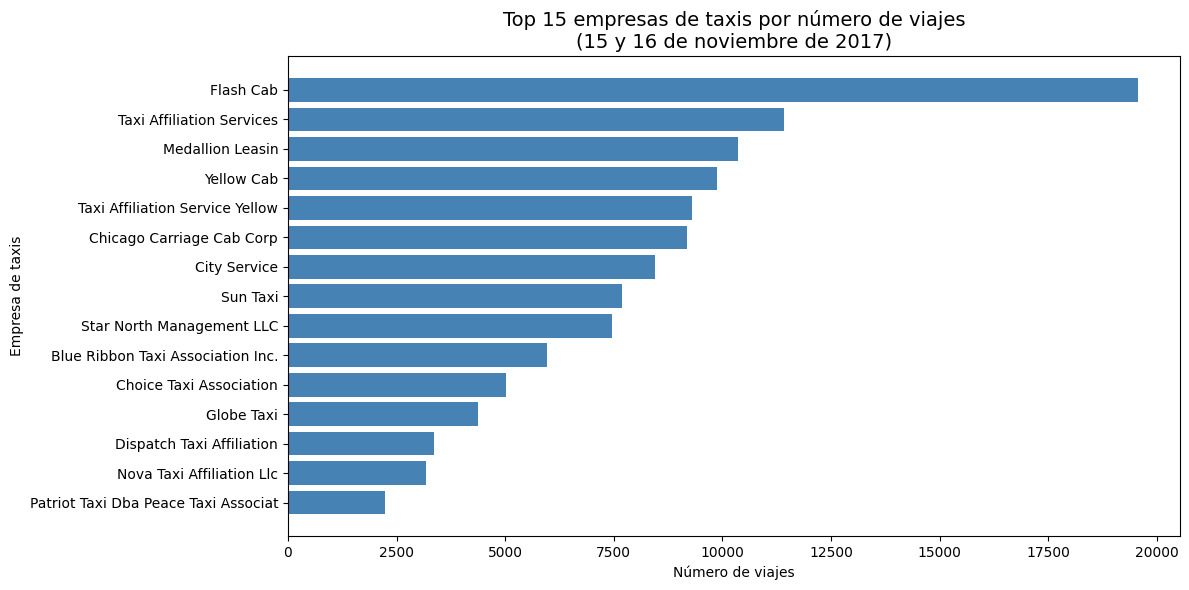

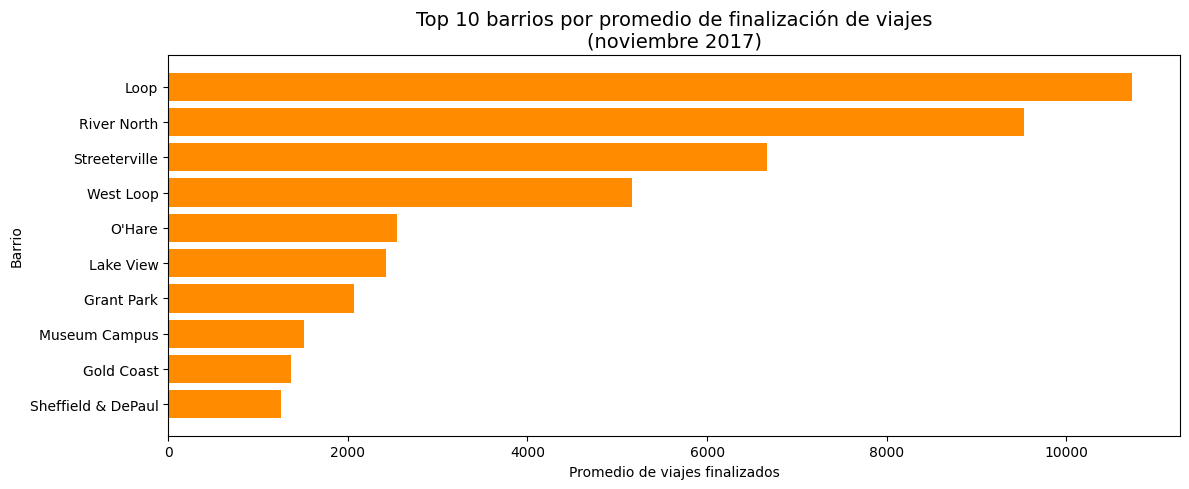

In [10]:
# Paso 5: Gráfico — Empresas de taxis y número de viajes
# Mostrar solo las 15 empresas principales
top15_companies = df_companies_sorted.head(15)

plt.figure(figsize=(12, 6))
plt.barh(top15_companies['company_name'],
         top15_companies['trips_amount'], color='steelblue')
plt.title('Top 15 empresas de taxis por número de viajes\n(15 y 16 de noviembre de 2017)', fontsize=14)
plt.xlabel('Número de viajes')
plt.ylabel('Empresa de taxis')
plt.gca().invert_yaxis()  # Empresa con más viajes arriba
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Gráfico — 10 barrios principales por promedio de viajes finalizados
plt.figure(figsize=(12, 5))
plt.barh(top10_locations['dropoff_location_name'],
         top10_locations['average_trips'], color='darkorange')
plt.title('Top 10 barrios por promedio de finalización de viajes\n(noviembre 2017)', fontsize=14)
plt.xlabel('Promedio de viajes finalizados')
plt.ylabel('Barrio')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
# Paso 5. Prueba de hipótesis (Python)
# Cargar datos
df_rain = pd.read_csv('moved_project_sql_result_07.csv')

# Convertir a tipo fecha para filtrar sábados
df_rain['start_ts'] = pd.to_datetime(df_rain['start_ts'])
df_rain['weekday'] = df_rain['start_ts'].dt.dayofweek  # 5 = sábado

# Filtrar solo sábados
df_saturdays = df_rain[df_rain['weekday'] == 5]

# Separar por clima
group_rain = df_saturdays[df_saturdays['weather_conditions']
                          == 'Bad']['duration_seconds']
group_clear = df_saturdays[df_saturdays['weather_conditions']
                           == 'Good']['duration_seconds']

# Aplicar la prueba de Mann–Whitney U
stat, p_value = mannwhitneyu(group_rain, group_clear, alternative='two-sided')

# Función para detectar valores atípicos con el método IQR
def detectar_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)]
    return outliers

# Detectar outliers
outliers_rain = detectar_outliers(group_rain)
outliers_clear = detectar_outliers(group_clear)

# Mostrar resultados
print(f"Outliers en sábados con lluvia: {len(outliers_rain)}")
print(f"Outliers en sábados con clima despejado: {len(outliers_clear)}")

# Estadísticas adicionales
print("\nResumen estadístico - Lluvia:")
print(group_rain.describe())
print("\nResumen estadístico - Clima despejado:")
print(group_clear.describe())

Outliers en sábados con lluvia: 3
Outliers en sábados con clima despejado: 6

Resumen estadístico - Lluvia:
count     180.000000
mean     2427.205556
std       721.314138
min       480.000000
25%      1962.000000
50%      2540.000000
75%      2928.000000
max      4980.000000
Name: duration_seconds, dtype: float64

Resumen estadístico - Clima despejado:
count     888.000000
mean     1999.675676
std       759.198268
min         0.000000
25%      1389.750000
50%      1800.000000
75%      2460.000000
max      7440.000000
Name: duration_seconds, dtype: float64


C:\Users\Elian\AppData\Local\Temp\ipykernel_13416\2122067677.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group_rain, group_clear], labels=['Lluvia', 'Despejado'])


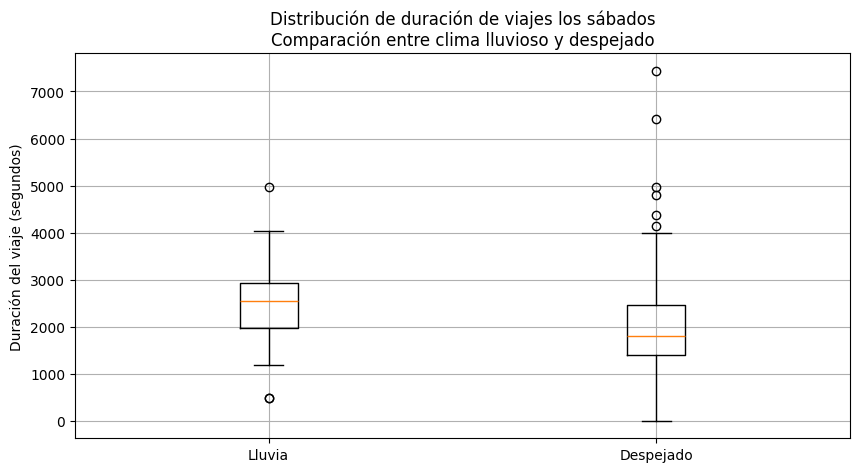

Estadístico U: 108193.5
Valor p: 6.716538885593458e-14
Rechazamos la hipótesis nula: hay diferencia significativa en las duraciones.


In [12]:
# Visualización con boxplots (solo matplotlib)
plt.figure(figsize=(10, 5))
plt.boxplot([group_rain, group_clear], labels=['Lluvia', 'Despejado'])
plt.title('Distribución de duración de viajes los sábados\nComparación entre clima lluvioso y despejado')
plt.ylabel('Duración del viaje (segundos)')
plt.grid(True)
plt.show()

print("Estadístico U:", stat)
print("Valor p:", p_value)

# Resultado de la prueba
if p_value < 0.05: #alfa
    print("Rechazamos la hipótesis nula: hay diferencia significativa en las duraciones.")
else:
    print("No se rechaza la hipótesis nula: no hay evidencia de diferencia significativa.")